In [1]:
import rebound
%matplotlib inline
import matplotlib.pyplot as plt
import observations
import state

/Users/rein/git/rebound/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
true_state = state.State(planets=[{"m":1e-3, "a":1., "h":0.2}])
obs = observations.FakeObservation(true_state, Npoints=100, error=1e-4, tmax=10.)

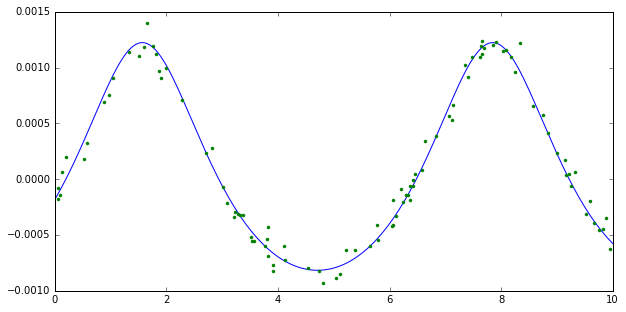

In [3]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
times, rv = true_state.get_rv_plotting(tmax=10.)
ax.plot(times, rv)
ax.plot(obs.t, obs.rv, ".")

In [4]:
true_state.get_chi2(obs)

0.78934770406395649

In [5]:
varState = state.StateVar(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0.}], ignore_vars=["a","m"])

varState.get_chi2(obs)

0.78934770406395649

In [6]:
print(varState.planets_vars)

[['h', 'k']]


In [7]:
varState.get_chi2_d_dd(obs)

(0.78934770406396526,
 array([ 2.00827352,  1.89737353]),
 array([[ 110.25274827,   -4.00757658],
        [  -4.00757658,  111.11219841]]))

In [9]:
Delta = 1e-4
s = state.State(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0.}])
sp = state.State(planets=[{"m":1e-3, "a":1., "h":0.2+Delta, "k":0.}])
sm = state.State(planets=[{"m":1e-3, "a":1., "h":0.2-Delta, "k":0.}])

(sp.get_chi2(obs)-s.get_chi2(obs))/Delta

2.0137860434599197